In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Работа с ансамблями

Эта работа является идейным продолжением предыдущей. В данной работе  поэкспериментируем с различными методами ансамблирования и проверим, какие из них работают лучше. Пайплайн предобработки данных возьмем из предыдущей работы.


# Загрузка и подготовка данных 

In [4]:
X_train = pd.read_csv("X_train")
X_test = pd.read_csv("X_test")

In [5]:
X_train["split"] = "train"
X_train

,number_of_reviews,number_of_answered_questions,average_review_rating,price,number_avaible,manufacturer_Amscan,manufacturer_Baker Ross,manufacturer_Bandai,manufacturer_Bristol Novelties,manufacturer_Bruder,...,amazon_category_and_sub_category_Hobbies > Trading Cards & Accessories > Packs & Sets,"amazon_category_and_sub_category_Party Supplies > Banners, Stickers & Confetti > Banners",amazon_category_and_sub_category_Party Supplies > Decorations > Balloons,amazon_category_and_sub_category_Puppets & Puppet Theatres > Hand Puppets,amazon_category_and_sub_category_other,condition_collectible,condition_new,condition_refurbished,condition_used,split
0,8.0,2.000000,4.6,1.50,3.0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,train
1,1.0,1.000000,5.0,6.60,2.0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,train
2,9.0,1.000000,4.9,1.64,10.0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,train
3,6.0,1.000000,4.8,6.50,4.0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,train
4,2.0,1.000000,5.0,89.34,2.0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4130,6.0,1.000000,4.3,2.58,12.0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,train
4131,12.0,1.000000,4.3,11.93,3.0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,train
4132,16.0,1.000000,4.0,24.99,7.0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,train
4133,1.0,1.000000,5.0,1.32,3.0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,train


In [6]:
X_test["split"] = "test"
df = pd.concat([X_train, X_test], axis=0)

In [7]:
X_train, y_train = X_train.drop(columns='price'), X_train.price
X_test, y_test = X_test.drop(columns='price'), X_test.price

In [8]:
from sklearn.model_selection import train_test_split

# Стекинг 

## Простой стекинг своими руками (2 балла)

In [9]:
class StackingRegressionSolver:
    def __init__(self, base_estimators: list, meta_estimator):
        self._base_estimators = base_estimators
        self._meta_estimator = meta_estimator

    def _fit_base(self, X: pd.DataFrame, y: pd.Series) -> None:
        for estimator in self._base_estimators:
            estimator.fit(X, y)

    def _predict_base(self, X: pd.DataFrame) -> pd.DataFrame:
        cnt = 1
        meta_data = pd.DataFrame()
        for x in self._base_estimators:
            meta_data[f"{cnt}"] = x.predict(X)
            cnt += 1
        return meta_data

    def fit(self, X: pd.DataFrame, y: pd.Series):
        self._fit_base(X, y)
        meta_features = self._predict_base(X)
        self._meta_estimator.fit(meta_features, y)


    def predict(self, X: pd.DataFrame) -> pd.Series:
        meta_features = self._predict_base(X)
        return self._meta_estimator.predict(meta_features)

In [10]:
from sklearn.metrics import mean_squared_error as mse, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR

In [11]:
X_train.drop(columns='split', inplace=True)
X_test.drop(columns='split', inplace=True)

In [12]:
lr = LinearRegression()
dt = DecisionTreeRegressor()
svr = LinearSVR()

estimator = [[[lr, svr], [dt]], [[lr, dt], [svr]], [[dt, svr], [lr]]]

for x in estimator:
    stacking_regressor = StackingRegressionSolver(base_estimators=x[0], meta_estimator=x[1][0])
    stacking_regressor.fit(X_train, y_train)
    y_pred = stacking_regressor.predict(X_test)
    print("Models:", x, ", result: ", "mse =", mse(y_test, y_pred),"R2_score =", r2_score(y_test, y_pred))

C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Models: [[LinearRegression(), LinearSVR()], [DecisionTreeRegressor()]] , result:  mse = 1930.9114782743297 R2_score = -0.25184805902098084
Models: [[LinearRegression(), DecisionTreeRegressor()], [LinearSVR()]] , result:  mse = 2100.0078275463416 R2_score = -0.3614765629712935
Models: [[DecisionTreeRegressor(), LinearSVR()], [LinearRegression()]] , result:  mse = 2095.9751792049437 R2_score = -0.3588621173813773


C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Лучший результат показала комбинация моделей [LinearRegression(), LinearSVR()], [DecisionTreeRegressor()]

Попробуем перебрать гиперпараметры

In [13]:
eps = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
mse_score = 100000
r2 = -1
for depth in range(2, 11):
    for e in eps:
        lr = LinearRegression()
        dt = DecisionTreeRegressor(max_depth=depth)
        svr = LinearSVR(epsilon=e)
        
        stacking_regressor = StackingRegressionSolver(base_estimators=estimator[0][0], meta_estimator=estimator[0][1][0])
        stacking_regressor.fit(X_train, y_train)
        y_pred = stacking_regressor.predict(X_test)
        print("max_depth = ", depth, "epsilon =", e)
        print("mse =", mse(y_test, y_pred), "r2 =", r2_score(y_test, y_pred))
        if (mse(y_test, y_pred) < mse_score) and (r2 < r2_score(y_test, y_pred)):
            mse_score = mse(y_test, y_pred)
            ep = e
            d = depth
            r2 = r2_score(y_test, y_pred)
        print("-------------------------------------------")


C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


max_depth =  2 epsilon = 0.1
mse = 1785.6397243272158 r2 = -0.1576655109055196
-------------------------------------------
max_depth =  2 epsilon = 0.2
mse = 1898.9905517871753 r2 = -0.23115309174013543
-------------------------------------------


C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


max_depth =  2 epsilon = 0.3
mse = 1940.6849280528713 r2 = -0.25818437959956086
-------------------------------------------
max_depth =  2 epsilon = 0.4
mse = 1946.6997810824403 r2 = -0.2620839276498381
-------------------------------------------


C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


max_depth =  2 epsilon = 0.5
mse = 1867.1501755799134 r2 = -0.21051034679711966
-------------------------------------------
max_depth =  2 epsilon = 0.6
mse = 1827.6973386629138 r2 = -0.1849322931819657
-------------------------------------------


C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


max_depth =  2 epsilon = 0.7
mse = 1978.4745809919987 r2 = -0.282684158183508
-------------------------------------------
max_depth =  2 epsilon = 0.8
mse = 1870.2291927207918 r2 = -0.2125065344395205
-------------------------------------------
max_depth =  2 epsilon = 0.9
mse = 1828.904880785349 r2 = -0.18571516659649823
-------------------------------------------


C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


max_depth =  3 epsilon = 0.1
mse = 1970.5660532696754 r2 = -0.2775569034179235
-------------------------------------------


C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


max_depth =  3 epsilon = 0.2
mse = 1716.2914143004964 r2 = -0.11270563144956469
-------------------------------------------
max_depth =  3 epsilon = 0.3
mse = 1817.304046771353 r2 = -0.1781941167157317
-------------------------------------------
max_depth =  3 epsilon = 0.4
mse = 1912.4955356976316 r2 = -0.23990863961772302
-------------------------------------------


C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


max_depth =  3 epsilon = 0.5
mse = 2069.3253214695405 r2 = -0.34158448810907904
-------------------------------------------
max_depth =  3 epsilon = 0.6
mse = 1801.848094510736 r2 = -0.16817371751282972
-------------------------------------------


C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


max_depth =  3 epsilon = 0.7
mse = 1881.6289969790546 r2 = -0.21989725275804184
-------------------------------------------
max_depth =  3 epsilon = 0.8
mse = 1946.013742280763 r2 = -0.2616391551411261
-------------------------------------------


C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


max_depth =  3 epsilon = 0.9
mse = 1756.8498933721396 r2 = -0.13900049471696607
-------------------------------------------
max_depth =  4 epsilon = 0.1
mse = 1748.371807294315 r2 = -0.13350398401714747
-------------------------------------------


C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


max_depth =  4 epsilon = 0.2
mse = 1824.7284926631296 r2 = -0.18300753166690975
-------------------------------------------


C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


max_depth =  4 epsilon = 0.3
mse = 1952.009511713885 r2 = -0.2655263309188056
-------------------------------------------


C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


max_depth =  4 epsilon = 0.4
mse = 1880.5729331963319 r2 = -0.21921258574379565
-------------------------------------------
max_depth =  4 epsilon = 0.5
mse = 1823.793148398429 r2 = -0.1824011295011676
-------------------------------------------


C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


max_depth =  4 epsilon = 0.6
mse = 1880.9011992717808 r2 = -0.21942540712583058
-------------------------------------------
max_depth =  4 epsilon = 0.7
mse = 1890.0183463877227 r2 = -0.2253362337221385
-------------------------------------------


C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


max_depth =  4 epsilon = 0.8
mse = 1979.5400045382307 r2 = -0.28337489331735166
-------------------------------------------
max_depth =  4 epsilon = 0.9
mse = 1970.0918181269826 r2 = -0.2772494474057867
-------------------------------------------
max_depth =  5 epsilon = 0.1
mse = 1914.0758241290546 r2 = -0.2409331718284582
-------------------------------------------


C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


max_depth =  5 epsilon = 0.2
mse = 1984.1537873094394 r2 = -0.28636609983917705
-------------------------------------------
max_depth =  5 epsilon = 0.3
mse = 1968.9779899069945 r2 = -0.27652733056564993
-------------------------------------------
max_depth =  5 epsilon = 0.4
mse = 1913.2413405426425 r2 = -0.24039215963308402
-------------------------------------------


C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


max_depth =  5 epsilon = 0.5
mse = 1912.8477191600064 r2 = -0.24013696711422083
-------------------------------------------
max_depth =  5 epsilon = 0.6
mse = 1883.185586505726 r2 = -0.22090642050062392
-------------------------------------------


C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


max_depth =  5 epsilon = 0.7
mse = 1960.4787401065723 r2 = -0.2710170990063545
-------------------------------------------


C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


max_depth =  5 epsilon = 0.8
mse = 1791.557129266539 r2 = -0.16150188143367727
-------------------------------------------
max_depth =  5 epsilon = 0.9
mse = 1825.0365992241373 r2 = -0.18320728323745494
-------------------------------------------


C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


max_depth =  6 epsilon = 0.1
mse = 1813.8363591017146 r2 = -0.1759459462908466
-------------------------------------------
max_depth =  6 epsilon = 0.2
mse = 1900.9959424666204 r2 = -0.2324532261367085
-------------------------------------------
max_depth =  6 epsilon = 0.3
mse = 2021.6543532114256 r2 = -0.31067845758565693
-------------------------------------------


C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


max_depth =  6 epsilon = 0.4
mse = 1752.2086306900992 r2 = -0.13599147242604714
-------------------------------------------


C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


max_depth =  6 epsilon = 0.5
mse = 1791.2346455413974 r2 = -0.16129280886358477
-------------------------------------------
max_depth =  6 epsilon = 0.6
mse = 1823.0106250607896 r2 = -0.1818938041616145
-------------------------------------------


C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


max_depth =  6 epsilon = 0.7
mse = 1870.233267162904 r2 = -0.21250917598083774
-------------------------------------------
max_depth =  6 epsilon = 0.8
mse = 1845.6009400220482 r2 = -0.19653955165191284
-------------------------------------------


C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


max_depth =  6 epsilon = 0.9
mse = 1884.5088618241818 r2 = -0.22176432603259588
-------------------------------------------
max_depth =  7 epsilon = 0.1
mse = 1929.3049123005824 r2 = -0.25080649056040993
-------------------------------------------


C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


max_depth =  7 epsilon = 0.2
mse = 2026.9679136397458 r2 = -0.31412334378760143
-------------------------------------------
max_depth =  7 epsilon = 0.3
mse = 1889.4819087246349 r2 = -0.22498845058713846
-------------------------------------------
max_depth =  7 epsilon = 0.4
mse = 1817.4916448054198 r2 = -0.17831574022745933
-------------------------------------------


C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


max_depth =  7 epsilon = 0.5
mse = 1928.6611446421398 r2 = -0.2503891232689781
-------------------------------------------
max_depth =  7 epsilon = 0.6
mse = 1869.3791300304026 r2 = -0.21195542200325224
-------------------------------------------


C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


max_depth =  7 epsilon = 0.7
mse = 1873.2585384113765 r2 = -0.2144705190993721
-------------------------------------------
max_depth =  7 epsilon = 0.8
mse = 1875.5857658248551 r2 = -0.21597930660892017
-------------------------------------------


C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


max_depth =  7 epsilon = 0.9
mse = 1854.6945914748114 r2 = -0.20243514554559505
-------------------------------------------
max_depth =  8 epsilon = 0.1
mse = 1740.5077433097797 r2 = -0.1284055559712094
-------------------------------------------


C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


max_depth =  8 epsilon = 0.2
mse = 2019.5037790781755 r2 = -0.309284197887695
-------------------------------------------
max_depth =  8 epsilon = 0.3
mse = 1923.2138334226202 r2 = -0.24685752378667924
-------------------------------------------


C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


max_depth =  8 epsilon = 0.4
mse = 1844.0247170221999 r2 = -0.19551765514078534
-------------------------------------------
max_depth =  8 epsilon = 0.5
mse = 1970.0738438289738 r2 = -0.277237794313282
-------------------------------------------
max_depth =  8 epsilon = 0.6
mse = 1926.3637571390734 r2 = -0.24889968156287634
-------------------------------------------


C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


max_depth =  8 epsilon = 0.7
mse = 2003.0752519300308 r2 = -0.29863325917073325
-------------------------------------------
max_depth =  8 epsilon = 0.8
mse = 1925.9158611219696 r2 = -0.2486093017262221
-------------------------------------------


C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


max_depth =  8 epsilon = 0.9
mse = 1824.8708161104817 r2 = -0.18309980276961202
-------------------------------------------
max_depth =  9 epsilon = 0.1
mse = 2060.839588017903 r2 = -0.3360830194657338
-------------------------------------------


C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


max_depth =  9 epsilon = 0.2
mse = 2060.8745281700512 r2 = -0.3361056718566593
-------------------------------------------


C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


max_depth =  9 epsilon = 0.3
mse = 2001.8150307336302 r2 = -0.2978162328718055
-------------------------------------------
max_depth =  9 epsilon = 0.4
mse = 1892.426629543598 r2 = -0.22689757127084387
-------------------------------------------


C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


max_depth =  9 epsilon = 0.5
mse = 1922.122858666596 r2 = -0.24615022329873004
-------------------------------------------
max_depth =  9 epsilon = 0.6
mse = 1919.5747608443505 r2 = -0.2444982411395975
-------------------------------------------


C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


max_depth =  9 epsilon = 0.7
mse = 1839.1023452543614 r2 = -0.19232638427586957
-------------------------------------------
max_depth =  9 epsilon = 0.8
mse = 1807.2114207169413 r2 = -0.17165086785176453
-------------------------------------------


C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


max_depth =  9 epsilon = 0.9
mse = 1838.4737314132167 r2 = -0.1919188415035753
-------------------------------------------


C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


max_depth =  10 epsilon = 0.1
mse = 1927.2717683757214 r2 = -0.24948836318653256
-------------------------------------------
max_depth =  10 epsilon = 0.2
mse = 1828.7947440445612 r2 = -0.18564376277155148
-------------------------------------------


C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


max_depth =  10 epsilon = 0.3
mse = 1961.9688741892796 r2 = -0.2719831823717014
-------------------------------------------
max_depth =  10 epsilon = 0.4
mse = 2126.9662278892606 r2 = -0.3789542265117034
-------------------------------------------


C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


max_depth =  10 epsilon = 0.5
mse = 1759.3487233190358 r2 = -0.1406205355391592
-------------------------------------------
max_depth =  10 epsilon = 0.6
mse = 1825.4587194254382 r2 = -0.18348095210348947
-------------------------------------------
max_depth =  10 epsilon = 0.7
mse = 1804.7501329423362 r2 = -0.17005516636156215
-------------------------------------------


C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


max_depth =  10 epsilon = 0.8
mse = 2195.5351384111373 r2 = -0.4234088058706227
-------------------------------------------
max_depth =  10 epsilon = 0.9
mse = 1824.0608724652848 r2 = -0.18257470030294587
-------------------------------------------


C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Лучшие гиперпараметры и результат ошибки при них

In [14]:
print("epsilon =", ep, "max_depth =", d)
print("mse =", mse_score, "r2_score =", r2)

epsilon = 0.2 max_depth = 3
mse = 1716.2914143004964 r2_score = -0.11270563144956469


## Использование встроенной модели стекинга (0.5 балла)

In [15]:
from sklearn.ensemble import StackingRegressor

estimators = [("lin_reg", LinearRegression()), ("svr", LinearSVR())]
clf = StackingRegressor(estimators=estimators, final_estimator=dt)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(f'mse: {mse(y_test, y_pred)}, r2_score: {r2_score(y_test, y_pred)}\n')

C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warni

mse: 1893.802385803341, r2_score: -0.22778950123388086



C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


## Блендинг (0.5 балла)


In [16]:
class BlandingRegressionSolver:
    def __init__(self, base_estimators: list, meta_estimator):
        self._base_estimators = base_estimators
        self._meta_estimator = meta_estimator

    def _fit_base(self, X: pd.DataFrame, y: pd.Series) -> None:
        for estimator in self._base_estimators:
            estimator.fit(X, y)

    def _predict_base(self, X: pd.DataFrame) -> pd.DataFrame:
        cnt = 1
        meta_data = pd.DataFrame()
        for x in self._base_estimators:
            meta_data[f"{cnt}"] = x.predict(X)
            cnt += 1
        return meta_data

    def fit(self, X_train: pd.DataFrame, y_train: pd.Series, X_valid: pd.DataFrame, y_valid: pd.Series):
        self._fit_base(X_train, y_train)
        meta_features = self._predict_base(X_valid)
        self._meta_estimator.fit(meta_features, y_valid)


    def predict(self, X: pd.DataFrame) -> pd.Series:
        meta_features = self._predict_base(X)
        return self._meta_estimator.predict(meta_features)

In [17]:
X_valid, X_test_new, y_valid, y_test_new = train_test_split(X_test, y_test, train_size=0.5, random_state=42)

for x in estimator:
    stacking_regressor = BlandingRegressionSolver(base_estimators=x[0], meta_estimator=x[1][0])
    stacking_regressor.fit(X_train, y_train, X_valid, y_valid)
    y_pred = stacking_regressor.predict(X_test)
    print("Models:", x, ", result: ", "mse =", mse(y_test, y_pred),"R2_score =", r2_score(y_test, y_pred))

C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Models: [[LinearRegression(), LinearSVR()], [DecisionTreeRegressor()]] , result:  mse = 1337.9143140540034 R2_score = 0.13260371796964465
Models: [[LinearRegression(), DecisionTreeRegressor()], [LinearSVR()]] , result:  mse = 1577.158262489606 R2_score = -0.02250286037504856
Models: [[DecisionTreeRegressor(), LinearSVR()], [LinearRegression()]] , result:  mse = 1459.398410084293 R2_score = 0.053843178437635086


C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Качество заметно улучшилось

# Бэггинг 

## Бэггинг своими руками (2 балла)

In [18]:
from typing import Tuple


class BaggingRegressionSolver:
    def __init__(
        self,
        base_estimator_ctor,
        max_samples,
        n_estimators: int = 10,
        sample_random_state=42,
        **model_kwargs
    ):
        if max_samples < 0 or max_samples > 1:
            raise ValueError
        self._estimators = [
            base_estimator_ctor(**model_kwargs) for _ in range(n_estimators)
        ]
        self._max_samples = max_samples
        self._random_state = sample_random_state

    def _sample_data(self, X: pd.DataFrame, y: pd.Series) -> Tuple[pd.DataFrame, pd.Series]:
        x_i = X.sample(frac=self._max_samples, random_state=self._random_state)
        y_i = y.loc[x_i.index]
        return x_i, y_i

    def fit(self, X: pd.DataFrame, y: pd.Series):
        for estimator in self._estimators:
            x_i, y_i = self._sample_data(X, y)
            estimator.fit(x_i, y_i)

    def predict(self, X: pd.DataFrame) -> pd.Series:
        ans = pd.DataFrame()
        for i, x in enumerate(self._estimators):
            ans[f'{i}'] = x.predict(X)
        return ans.mean(axis=1)

In [19]:
estimators = [LinearRegression, DecisionTreeRegressor, LinearSVR]

for x in estimators:
    bagging = BaggingRegressionSolver(x, n_estimators=10, max_samples=0.7)
    bagging.fit(X_train, y_train)
    y_pred = bagging.predict(X_test)
    print("Models:", x, ", result: ", "mse =", mse(y_test, y_pred),"R2_score =", r2_score(y_test, y_pred))

Models: <class 'sklearn.linear_model._base.LinearRegression'> , result:  mse = 1441.6620661155575 R2_score = 0.06534200063700013
Models: <class 'sklearn.tree._classes.DecisionTreeRegressor'> , result:  mse = 1848.8823569770495 R2_score = -0.19866695909247967


C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warni

Models: <class 'sklearn.svm._classes.LinearSVR'> , result:  mse = 1567.5880688736365 R2_score = -0.01629831478225241


C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Лучший результат показала линейная регрессия, возможно это потому что для деревьев и svm необходимо подбирать корректные параметры для лучшей работы

## Использование встроенной модели бэггинга 



In [20]:
from sklearn.ensemble import BaggingRegressor

estimators = [LinearRegression(), DecisionTreeRegressor(), LinearSVR()]

for x in estimators:
    model = BaggingRegressor(base_estimator=x, n_estimators=10, random_state=12)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print("Models:", x, ", result: ", "mse =", mse(y_test, y_pred),"R2_score =", r2_score(y_test, y_pred))

Models: LinearRegression() , result:  mse = 1433.4868284798677 R2_score = 0.07064216870861983
Models: DecisionTreeRegressor() , result:  mse = 1610.0310546031162 R2_score = -0.04381494094679783


C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warni

Models: LinearSVR() , result:  mse = 1568.7316043896726 R2_score = -0.017039691449323158


C:\Users\sav4u\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [21]:
from sklearn.ensemble import RandomForestRegressor

regr = RandomForestRegressor()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)
print("mse =", mse(y_test, y_pred),"R2_score =", r2_score(y_test, y_pred))

mse = 1563.956535590414 R2_score = -0.013943920009098498


Лучший результат показала линейная регрессия, но попробуем подобрать параметры для деревьев

In [22]:
mse_score = 1800
r2=-1
for i in range(20, 100, 10):
    for j in range(3, 10, 2):
        regr = RandomForestRegressor(n_estimators=i, max_depth=j)
        regr.fit(X_train, y_train)
        y_pred = regr.predict(X_test)
        print("max_depth = ", j, "n_estimators =", i)
        print("mse =", mse(y_test, y_pred), "r2 =", r2_score(y_test, y_pred))
        if (mse(y_test, y_pred) < mse_score) and (r2 < r2_score(y_test, y_pred)):
            mse_score = mse(y_test, y_pred)
            n = i
            d = j
            r2 = r2_score(y_test, y_pred)
        print("-------------------------------------------")

max_depth =  3 n_estimators = 20
mse = 1571.8470830368415 r2 = -0.019059517806596205
-------------------------------------------
max_depth =  5 n_estimators = 20
mse = 1622.2696853311613 r2 = -0.05174948703778193
-------------------------------------------
max_depth =  7 n_estimators = 20
mse = 1467.1919484079958 r2 = 0.04879047357094046
-------------------------------------------
max_depth =  9 n_estimators = 20
mse = 1468.7023755953603 r2 = 0.0478112337849278
-------------------------------------------
max_depth =  3 n_estimators = 30
mse = 1559.155972368717 r2 = -0.010831620031131806
-------------------------------------------
max_depth =  5 n_estimators = 30
mse = 1543.4579474674576 r2 = -0.0006542803528430952
-------------------------------------------
max_depth =  7 n_estimators = 30
mse = 1489.0727838121138 r2 = 0.03460469569422364
-------------------------------------------
max_depth =  9 n_estimators = 30
mse = 1468.6502387812573 r2 = 0.047845035111541034
---------------------

In [23]:
print("Лучший показатель")
print("n_estimators =",n , "max_depth =", d)
print("mse =", mse_score, "r2_score =", r2)

Лучший показатель
n_estimators = 20 max_depth = 7
mse = 1467.1919484079958 r2_score = 0.04879047357094046


# Бустинг

## Бустинг своими руками (2 балла)


In [25]:
from abc import ABC, abstractmethod
from collections import deque
from typing import Tuple

from sklearn.dummy import DummyRegressor


class Loss(ABC):
    """
    Базовый класс для функции потерь
    """
    @abstractmethod
    def forward(self, y_true: pd.Series, y_pred: pd.Series) -> float:
        """
        Метод, вычисляющий значение функции потерь
        """
        pass

    @abstractmethod
    def backward(self, y_true: pd.Series, y_pred: pd.Series) -> pd.Series:
        """
        Метод, вычисляющий значение градиента функции потерь по предсказаниям модели
        """
        pass


class MSELoss(Loss):
    def forward(self, y_pred: pd.Series, y_true: pd.Series) -> float:  # посчитаем значение ошибки
        return ((np.array(y_pred) - np.array(y_true)) ** 2).mean()

    def backward(self, y_pred: pd.Series, y_true: pd.Series) -> pd.Series:  # посчитаем производную по выходам модели
        return np.array(y_true) - np.array(y_pred)


class GradientBoostingRegressionSolver:
    def __init__(
        self,
        base_estimator_ctor,
        n_estimators: int = 10,
        loss: Loss = MSELoss(),
        learning_rate: float = 0.1,
        early_stopping: int = 5,
        **model_kwargs
    ):
        if early_stopping < 0:
            raise ValueError

        self._ctor = base_estimator_ctor
        self._kwargs = model_kwargs
        self._n_estimators = n_estimators
        self._estimators = []
        self._early_stopping = early_stopping
        self._loss = loss
        self._lr = learning_rate
        self._random_state = 42

    def _sample_data(self, X: pd.DataFrame, y: pd.Series, frac: float) -> Tuple[pd.DataFrame, pd.Series]:
        x_sample = X.sample(frac=frac, random_state=self._random_state)
        y_sample = y.loc[x_sample.index]
        return x_sample, y_sample

    def _split_data(self, X: pd.DataFrame, y: pd.Series, val_size: float) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:
        x_val, y_val = self._sample_data(X, y, val_size)
        x_train, y_train = X[~X.index.isin(x_val.index)], y[~y.index.isin(y_val.index)]
        return x_train, x_val, y_train, y_val

    def predict(self, X: pd.DataFrame) -> pd.Series:
        data = pd.DataFrame()
        for i, x in enumerate(self._estimators):
            data[f'{i}'] = x.predict(X)
        return data.sum(axis=1)

    def fit(self, X: pd.DataFrame, y: pd.Series, val_size: float = 0.1):
        x_train, x_val, y_train, y_val = self._split_data(X, y, val_size)  # Хотим получить валидационную выборку, не тратя на это время снаружи
        base_estimator = DummyRegressor()  # Создадим и обучим базовую модель
        base_estimator.fit(x_train, y_train)
        self._estimators.append(base_estimator)  # Добавим базовую модель в список моделей

        y_pred_train, y_pred_val = base_estimator.predict(x_train), base_estimator.predict(x_val)  # Посчитаем предсказания как на обучающей, так и на валидационной выборках
        train_loss= self._loss.forward(y_pred_train, y_train)  # Посчитаем значение функции потерь для обучения
        val_loss = self._loss.forward(y_pred_val, y_val) # Посчитаем значение функции потерь для валидации
        residuals = self._loss.backward(y_pred_train, y_train)*self._lr  # Посчитаем остатки, используя градиент функции потерь
        
        print(f'train loss: {train_loss}, val loss: {val_loss}')
     
        previous_val_loss, cnt = val_loss, 0
        for i in range(self._n_estimators - 1):
            estimator = self._ctor(**self._kwargs)  # Создадим очередную модель
            # 1. Обучим её и добавим в список моделей
            estimator.fit(x_train, residuals)
            self._estimators.append(estimator)
            # 2. Предскажем ВСЕМ ансамблем данные из обучающей выборки, то же самое сделаем для валидационной
            y_pred_train = self.predict(x_train)
            y_pred_val = self.predict(x_val)
            # 3. Посчитаем значения функции потерь (на обучении и валидации)
            train_loss = self._loss.forward(y_pred_train, y_train)
            val_loss =  self._loss.forward(y_pred_val, y_val)
            # 4. Обновим остатки для обучающей выборки
            residuals = self._loss.backward(y_pred_train, y_train) * self._lr
            
            print(f'train loss: {train_loss}, val loss: {val_loss}')
            # Если валидационный лосс несколько (self._early_stopping) шагов подряд не уменьшается, то остановим обучение
            if previous_val_loss == val_loss:
                cnt += 1
            else:
                cnt = 0
            previous_val_loss = val_loss
            if cnt == self._early_stopping:
                print(f'Валидационный лосс несколько шагов = {self._early_stopping} не уменьшается')
                break

Вопросы на дополнительный балл:
- Почему градиент по ответам мы берем со знаком минус?
- Почему в обучении мы домножаем на `learning_rate`, а в предсказаниях этого не делаем?

1)Потому что мы ищем минимальное значение функции

In [26]:
estimators = [LinearRegression, DecisionTreeRegressor, RandomForestRegressor]

for x in estimators:
    boost = GradientBoostingRegressionSolver(x)
    boost.fit(X_train, y_train)
    y_pred = boost.predict(X_test)

    print(f'base_estimator_ctor: {x}')
    print(f'mse: {mse(y_test, y_pred)}, r2_score: {r2_score(y_test, y_pred)}')
    print('==========================================')

train loss: 1100.3419290353834, val loss: 586.5082683988813
train loss: 1080.950609394889, val loss: 572.7706821503102
train loss: 1065.2436404860885, val loss: 562.406518392163
train loss: 1052.5209956699603, val loss: 554.6984987409395
train loss: 1042.2156533688963, val loss: 549.073260517037
train loss: 1033.8683261050344, val loss: 545.0732494799055
train loss: 1027.1069910213064, val loss: 542.3340292716354
train loss: 1021.6303096034866, val loss: 540.5659707615624
train loss: 1017.1941976550527, val loss: 539.5394822411668
train loss: 1013.6009469768213, val loss: 539.0731015251331
base_estimator_ctor: <class 'sklearn.linear_model._base.LinearRegression'>
mse: 1455.0188937240011, r2_score: 0.05668250541702691
train loss: 1100.3419290353834, val loss: 586.5082683988813
train loss: 948.1603676623253, val loss: 577.5308661362935
train loss: 824.8933029501483, val loss: 577.8070197390588
train loss: 725.0469805332847, val loss: 583.0245027845549
train loss: 644.1714593756253, val l

Лучший результат вновь показала линейная регрессия, random forest немножко хуже, попробуем подобрать под него гиперпараметры

In [27]:
import seaborn as sns

def plot_fitting_curve(parameter: str, values: list, X_train, X_test, y_train, y_test):
    train_curve = []
    test_curve = []
    for value in values:
        model = GradientBoostingRegressionSolver(base_estimator_ctor=RandomForestRegressor, **{parameter: value})
        model.fit(X_train, y_train)
        y_pred_train, y_pred_test = model.predict(X_train), model.predict(X_test)
        train_curve.append(mse(y_train, y_pred_train))
        test_curve.append(mse(y_test, y_pred_test))
    sns.lineplot(x=values, y=train_curve, label='train')
    sns.lineplot(x=values, y=test_curve, label='test').set_title(f'{parameter}')

train loss: 1100.3419290353834, val loss: 586.5082683988813
train loss: 1066.2124331726739, val loss: 577.6577984016146
train loss: 1034.5106325448546, val loss: 571.3761781066081
train loss: 1010.6220957623398, val loss: 565.5741659206208
train loss: 990.5454641459972, val loss: 560.5125522164446
train loss: 971.7987448859128, val loss: 556.3681016740063
train loss: 955.4178185392169, val loss: 553.0214911942189
train loss: 940.167781072183, val loss: 550.3100649687271
train loss: 925.5484159581231, val loss: 547.3165436598102
train loss: 912.8181732257956, val loss: 544.9135518221677
train loss: 1100.3419290353834, val loss: 586.5082683988813
train loss: 1062.7770442426652, val loss: 575.4489603502867
train loss: 1026.9301987176025, val loss: 566.3679535537684
train loss: 991.2155467583598, val loss: 559.1267855264899
train loss: 961.038618545772, val loss: 552.7349437549764
train loss: 933.6782889137601, val loss: 548.020031237594
train loss: 909.8866205435903, val loss: 543.9079075

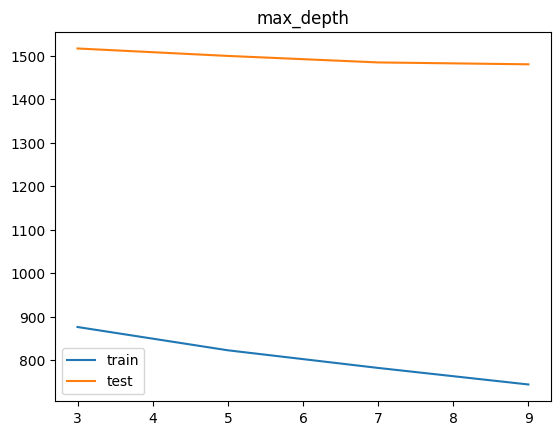

In [177]:
plot_fitting_curve('max_depth', range(3, 10, 2), X_train, X_test, y_train, y_test)

Оптимальная глубина равна 3

In [30]:
learning_rate = [0.01, 0.05, 0.01]
mse_score = 2000
r2=-1
for i in range(10, 50, 10): # n_estimators
    for j in learning_rate:# learning rate
        boost = GradientBoostingRegressionSolver(base_estimator_ctor=RandomForestRegressor, learning_rate=j, n_estimators=i)
        boost.fit(X_train, y_train)
        y_pred = boost.predict(X_test)
        if (mse(y_test, y_pred) < mse_score) and (r2 < r2_score(y_test, y_pred)):
            mse_score = mse(y_test, y_pred)
            n = i
            step = j
            r2 = r2_score(y_test, y_pred)

train loss: 1100.3419290353834, val loss: 586.5082683988813
train loss: 1089.4318012232804, val loss: 584.585445581818
train loss: 1078.1073140982546, val loss: 582.6393110594427
train loss: 1066.9979311644097, val loss: 580.8953495943692
train loss: 1055.9742174764617, val loss: 579.0494710309487
train loss: 1045.1994152391117, val loss: 577.4276932909353
train loss: 1034.8317740025605, val loss: 575.6860032655793
train loss: 1024.2428340245988, val loss: 574.0793301948862
train loss: 1013.91907589868, val loss: 572.5046721035684
train loss: 1004.0238679114916, val loss: 571.0534831480907
train loss: 1100.3419290353834, val loss: 586.5082683988813
train loss: 1044.5949756832078, val loss: 577.3924873282563
train loss: 994.3254099922859, val loss: 569.4859271322548
train loss: 948.2990507507574, val loss: 562.9387836209402
train loss: 905.4377775337892, val loss: 557.5357997333531
train loss: 865.2299760456839, val loss: 552.9402571062452
train loss: 826.6828175028988, val loss: 549.46

train loss: 526.2708942826512, val loss: 551.1435213313525
train loss: 512.9399661977817, val loss: 553.0465335064657
train loss: 499.96557364131064, val loss: 554.9192672660018
train loss: 488.656112560226, val loss: 557.0722111641579
train loss: 477.563430861538, val loss: 559.2176498404548
train loss: 467.16064242482537, val loss: 561.5471756126782
train loss: 457.53895724408875, val loss: 563.8265987407408
train loss: 448.38043743891393, val loss: 566.2107659810837
train loss: 440.2375506250019, val loss: 568.4692212236448
train loss: 432.3676680193192, val loss: 571.1132956912708
train loss: 424.67109009219934, val loss: 573.6229818759051
train loss: 1100.3419290353834, val loss: 586.5082683988813
train loss: 1089.549645527083, val loss: 584.5679614833084
train loss: 1078.1667561202923, val loss: 582.676618236
train loss: 1067.032114686964, val loss: 580.8507533862191
train loss: 1056.7263118286558, val loss: 579.0535669431673
train loss: 1046.369320492944, val loss: 577.432941704

train loss: 922.7811711634204, val loss: 559.3374770034969
train loss: 914.3658978519022, val loss: 558.4089868500716
train loss: 906.482073218578, val loss: 557.3999827134265
train loss: 898.0728849802663, val loss: 556.4051741137578
train loss: 889.9542300449511, val loss: 555.4632295459232
train loss: 881.9379063140171, val loss: 554.6566035324987
train loss: 874.3840681260191, val loss: 553.8193395178209
train loss: 866.9033007881336, val loss: 552.88014144191
train loss: 859.3381092895453, val loss: 552.089757848887
train loss: 851.7845969895995, val loss: 551.3061171032874
train loss: 844.4030523324324, val loss: 550.6125855223937
train loss: 837.2229436318114, val loss: 550.0021215458959
train loss: 830.0678680218922, val loss: 549.3684986372326
train loss: 822.6902506723817, val loss: 548.7197036665146
train loss: 815.8448543746501, val loss: 548.1415746761662
train loss: 808.9628242726773, val loss: 547.5990649531915
train loss: 802.1194765677872, val loss: 547.0881030356893
t

с подобранными параметрами результат получился такой же как у линейной регрессии

In [31]:
print("Лучший показатель")
print("n_estimators =",n , "max_depth =", 3, "lr =", step)
print("mse =", mse_score, "r2_score =", r2)

Лучший показатель
n_estimators = 10 max_depth = 3 lr = 0.05
mse = 1491.2384840960158 r2_score = 0.033200629413957405


# Catboost 

In [32]:
from catboost import CatBoostRegressor

cb = CatBoostRegressor(random_state=42)
cb.fit(X_train, y_train)
y_pred = cb.predict(X_test)
print(f'MSE = {mse(y_test, y_pred)}')
print(f'R_2 = {r2_score(y_test, y_pred)}')

Learning rate set to 0.051237
0:	learn: 32.2612607	total: 145ms	remaining: 2m 24s
1:	learn: 32.1364948	total: 148ms	remaining: 1m 13s
2:	learn: 32.0119759	total: 150ms	remaining: 49.7s
3:	learn: 31.9409338	total: 151ms	remaining: 37.6s
4:	learn: 31.8359045	total: 153ms	remaining: 30.5s
5:	learn: 31.7189542	total: 155ms	remaining: 25.7s
6:	learn: 31.6376013	total: 157ms	remaining: 22.3s
7:	learn: 31.5323341	total: 160ms	remaining: 19.8s
8:	learn: 31.4217420	total: 162ms	remaining: 17.8s
9:	learn: 31.3281155	total: 164ms	remaining: 16.2s
10:	learn: 31.2334613	total: 166ms	remaining: 14.9s
11:	learn: 31.1608934	total: 167ms	remaining: 13.8s
12:	learn: 31.0719458	total: 169ms	remaining: 12.9s
13:	learn: 30.9996603	total: 171ms	remaining: 12s
14:	learn: 30.9320914	total: 173ms	remaining: 11.3s
15:	learn: 30.8657299	total: 175ms	remaining: 10.7s
16:	learn: 30.7869002	total: 177ms	remaining: 10.2s
17:	learn: 30.7238859	total: 179ms	remaining: 9.75s
18:	learn: 30.6519419	total: 181ms	remaining

195:	learn: 26.7570788	total: 580ms	remaining: 2.38s
196:	learn: 26.7434583	total: 583ms	remaining: 2.38s
197:	learn: 26.7338764	total: 585ms	remaining: 2.37s
198:	learn: 26.7195018	total: 588ms	remaining: 2.37s
199:	learn: 26.7139530	total: 590ms	remaining: 2.36s
200:	learn: 26.7012548	total: 592ms	remaining: 2.35s
201:	learn: 26.6927954	total: 595ms	remaining: 2.35s
202:	learn: 26.6807386	total: 598ms	remaining: 2.35s
203:	learn: 26.6704995	total: 601ms	remaining: 2.35s
204:	learn: 26.6601626	total: 605ms	remaining: 2.34s
205:	learn: 26.6478925	total: 608ms	remaining: 2.34s
206:	learn: 26.6418292	total: 610ms	remaining: 2.34s
207:	learn: 26.6337363	total: 613ms	remaining: 2.33s
208:	learn: 26.6270570	total: 615ms	remaining: 2.33s
209:	learn: 26.6209938	total: 618ms	remaining: 2.32s
210:	learn: 26.6035001	total: 620ms	remaining: 2.32s
211:	learn: 26.5940193	total: 622ms	remaining: 2.31s
212:	learn: 26.5686596	total: 624ms	remaining: 2.31s
213:	learn: 26.5539392	total: 626ms	remaining:

356:	learn: 25.6623634	total: 972ms	remaining: 1.75s
357:	learn: 25.6551384	total: 975ms	remaining: 1.75s
358:	learn: 25.6503786	total: 978ms	remaining: 1.75s
359:	learn: 25.6465523	total: 981ms	remaining: 1.74s
360:	learn: 25.6414502	total: 984ms	remaining: 1.74s
361:	learn: 25.6386525	total: 987ms	remaining: 1.74s
362:	learn: 25.6345925	total: 990ms	remaining: 1.74s
363:	learn: 25.6312454	total: 993ms	remaining: 1.73s
364:	learn: 25.6283322	total: 996ms	remaining: 1.73s
365:	learn: 25.6205740	total: 999ms	remaining: 1.73s
366:	learn: 25.6155205	total: 1s	remaining: 1.73s
367:	learn: 25.6071124	total: 1s	remaining: 1.72s
368:	learn: 25.6010647	total: 1s	remaining: 1.72s
369:	learn: 25.5991779	total: 1.01s	remaining: 1.72s
370:	learn: 25.5956959	total: 1.01s	remaining: 1.72s
371:	learn: 25.5890891	total: 1.01s	remaining: 1.71s
372:	learn: 25.5828696	total: 1.01s	remaining: 1.71s
373:	learn: 25.5773768	total: 1.02s	remaining: 1.7s
374:	learn: 25.5704954	total: 1.02s	remaining: 1.7s
375:

520:	learn: 25.0074087	total: 1.36s	remaining: 1.25s
521:	learn: 25.0009359	total: 1.36s	remaining: 1.25s
522:	learn: 24.9963089	total: 1.36s	remaining: 1.25s
523:	learn: 24.9924111	total: 1.37s	remaining: 1.24s
524:	learn: 24.9904825	total: 1.37s	remaining: 1.24s
525:	learn: 24.9889583	total: 1.37s	remaining: 1.24s
526:	learn: 24.9834312	total: 1.38s	remaining: 1.24s
527:	learn: 24.9813955	total: 1.38s	remaining: 1.23s
528:	learn: 24.9802545	total: 1.38s	remaining: 1.23s
529:	learn: 24.9727344	total: 1.38s	remaining: 1.23s
530:	learn: 24.9690976	total: 1.39s	remaining: 1.22s
531:	learn: 24.9672495	total: 1.39s	remaining: 1.22s
532:	learn: 24.9649766	total: 1.39s	remaining: 1.22s
533:	learn: 24.9615215	total: 1.39s	remaining: 1.22s
534:	learn: 24.9595697	total: 1.4s	remaining: 1.21s
535:	learn: 24.9538427	total: 1.4s	remaining: 1.21s
536:	learn: 24.9488151	total: 1.4s	remaining: 1.21s
537:	learn: 24.9479332	total: 1.4s	remaining: 1.21s
538:	learn: 24.9453821	total: 1.41s	remaining: 1.2

762:	learn: 24.2570179	total: 1.94s	remaining: 602ms
763:	learn: 24.2545796	total: 1.94s	remaining: 600ms
764:	learn: 24.2518761	total: 1.94s	remaining: 597ms
765:	learn: 24.2494225	total: 1.95s	remaining: 595ms
766:	learn: 24.2457405	total: 1.95s	remaining: 592ms
767:	learn: 24.2418877	total: 1.95s	remaining: 589ms
768:	learn: 24.2411785	total: 1.95s	remaining: 587ms
769:	learn: 24.2383213	total: 1.96s	remaining: 584ms
770:	learn: 24.2335319	total: 1.96s	remaining: 582ms
771:	learn: 24.2301369	total: 1.96s	remaining: 580ms
772:	learn: 24.2272642	total: 1.97s	remaining: 577ms
773:	learn: 24.2262358	total: 1.97s	remaining: 574ms
774:	learn: 24.2258846	total: 1.97s	remaining: 572ms
775:	learn: 24.2199885	total: 1.97s	remaining: 569ms
776:	learn: 24.2195830	total: 1.97s	remaining: 566ms
777:	learn: 24.2146022	total: 1.98s	remaining: 564ms
778:	learn: 24.2130734	total: 1.98s	remaining: 561ms
779:	learn: 24.2115406	total: 1.98s	remaining: 559ms
780:	learn: 24.2098446	total: 1.98s	remaining:

945:	learn: 23.7908728	total: 2.33s	remaining: 133ms
946:	learn: 23.7888536	total: 2.33s	remaining: 131ms
947:	learn: 23.7863852	total: 2.34s	remaining: 128ms
948:	learn: 23.7854500	total: 2.34s	remaining: 126ms
949:	learn: 23.7830519	total: 2.34s	remaining: 123ms
950:	learn: 23.7814928	total: 2.34s	remaining: 121ms
951:	learn: 23.7782675	total: 2.35s	remaining: 118ms
952:	learn: 23.7779551	total: 2.35s	remaining: 116ms
953:	learn: 23.7761737	total: 2.35s	remaining: 113ms
954:	learn: 23.7752563	total: 2.35s	remaining: 111ms
955:	learn: 23.7727756	total: 2.36s	remaining: 108ms
956:	learn: 23.7703370	total: 2.36s	remaining: 106ms
957:	learn: 23.7696810	total: 2.36s	remaining: 103ms
958:	learn: 23.7680484	total: 2.36s	remaining: 101ms
959:	learn: 23.7667220	total: 2.37s	remaining: 98.5ms
960:	learn: 23.7650871	total: 2.37s	remaining: 96.1ms
961:	learn: 23.7640121	total: 2.37s	remaining: 93.6ms
962:	learn: 23.7617192	total: 2.37s	remaining: 91.1ms
963:	learn: 23.7598286	total: 2.37s	remain

Теперь на данных без предобработки

In [33]:
X_train_new = pd.DataFrame({
    "number_of_answered_questions" : X_train["number_of_answered_questions"],
    "number_of_reviews" : X_train["number_of_reviews"],
    "average_review_rating" : X_train["average_review_rating"]
}
)

In [34]:
X_test_new = pd.DataFrame({
    "number_of_answered_questions" : X_test["number_of_answered_questions"],
    "number_of_reviews" : X_test["number_of_reviews"],
    "average_review_rating" : X_test["average_review_rating"]
}
)

In [35]:
X_test_new

,number_of_answered_questions,number_of_reviews,average_review_rating
0,2.0,17.0,4.4
1,1.0,1.0,5.0
2,1.0,1.0,5.0
3,1.0,2.0,5.0
4,3.0,183.0,4.7
...,...,...,...
2182,2.0,1.0,5.0
2183,1.0,1.0,5.0
2184,1.0,1.0,5.0
2185,2.0,2.0,5.0


Качество ухудшилось

In [36]:
cb = CatBoostRegressor(random_state=42)
cb.fit(X_train_new, y_train)
y_pred = cb.predict(X_test_new)
print(f'MSE = {mse(y_test, y_pred)}')
print(f'R_2 = {r2_score(y_test, y_pred)}')

Learning rate set to 0.051237
0:	learn: 32.3129891	total: 2.25ms	remaining: 2.25s
1:	learn: 32.2197078	total: 5.06ms	remaining: 2.52s
2:	learn: 32.1505345	total: 15.1ms	remaining: 5.01s
3:	learn: 32.0543707	total: 18.7ms	remaining: 4.67s
4:	learn: 31.9662956	total: 21.7ms	remaining: 4.31s
5:	learn: 31.8805516	total: 25.7ms	remaining: 4.25s
6:	learn: 31.7928738	total: 28.4ms	remaining: 4.03s
7:	learn: 31.7117765	total: 31.4ms	remaining: 3.89s
8:	learn: 31.6274779	total: 34ms	remaining: 3.75s
9:	learn: 31.5484886	total: 36.7ms	remaining: 3.63s
10:	learn: 31.4729311	total: 39.9ms	remaining: 3.58s
11:	learn: 31.3959256	total: 42.5ms	remaining: 3.5s
12:	learn: 31.3244578	total: 44.9ms	remaining: 3.41s
13:	learn: 31.2527713	total: 47.6ms	remaining: 3.35s
14:	learn: 31.1824510	total: 50.2ms	remaining: 3.29s
15:	learn: 31.1124397	total: 53.5ms	remaining: 3.29s
16:	learn: 31.0469791	total: 56.2ms	remaining: 3.25s
17:	learn: 30.9805212	total: 58.9ms	remaining: 3.21s
18:	learn: 30.9176473	total: 

184:	learn: 28.2814883	total: 379ms	remaining: 1.67s
185:	learn: 28.2796514	total: 382ms	remaining: 1.67s
186:	learn: 28.2766578	total: 384ms	remaining: 1.67s
187:	learn: 28.2748825	total: 386ms	remaining: 1.67s
188:	learn: 28.2723997	total: 388ms	remaining: 1.67s
189:	learn: 28.2706178	total: 391ms	remaining: 1.67s
190:	learn: 28.2645494	total: 394ms	remaining: 1.67s
191:	learn: 28.2628223	total: 396ms	remaining: 1.67s
192:	learn: 28.2609179	total: 399ms	remaining: 1.67s
193:	learn: 28.2592659	total: 401ms	remaining: 1.67s
194:	learn: 28.2577534	total: 403ms	remaining: 1.66s
195:	learn: 28.2562528	total: 405ms	remaining: 1.66s
196:	learn: 28.2547201	total: 408ms	remaining: 1.66s
197:	learn: 28.2490906	total: 410ms	remaining: 1.66s
198:	learn: 28.2475560	total: 414ms	remaining: 1.66s
199:	learn: 28.2462003	total: 416ms	remaining: 1.66s
200:	learn: 28.2447623	total: 419ms	remaining: 1.66s
201:	learn: 28.2434735	total: 420ms	remaining: 1.66s
202:	learn: 28.2421835	total: 422ms	remaining:

384:	learn: 27.8106817	total: 770ms	remaining: 1.23s
385:	learn: 27.8079678	total: 773ms	remaining: 1.23s
386:	learn: 27.8053711	total: 775ms	remaining: 1.23s
387:	learn: 27.8023957	total: 777ms	remaining: 1.23s
388:	learn: 27.8003731	total: 779ms	remaining: 1.22s
389:	learn: 27.7999372	total: 782ms	remaining: 1.22s
390:	learn: 27.7952048	total: 784ms	remaining: 1.22s
391:	learn: 27.7934048	total: 790ms	remaining: 1.23s
392:	learn: 27.7930923	total: 794ms	remaining: 1.23s
393:	learn: 27.7917428	total: 797ms	remaining: 1.23s
394:	learn: 27.7893028	total: 800ms	remaining: 1.23s
395:	learn: 27.7889058	total: 804ms	remaining: 1.23s
396:	learn: 27.7829531	total: 807ms	remaining: 1.23s
397:	learn: 27.7814902	total: 809ms	remaining: 1.22s
398:	learn: 27.7813063	total: 812ms	remaining: 1.22s
399:	learn: 27.7787141	total: 814ms	remaining: 1.22s
400:	learn: 27.7772745	total: 817ms	remaining: 1.22s
401:	learn: 27.7764578	total: 819ms	remaining: 1.22s
402:	learn: 27.7749077	total: 821ms	remaining:

601:	learn: 27.4705283	total: 1.35s	remaining: 892ms
602:	learn: 27.4700219	total: 1.35s	remaining: 890ms
603:	learn: 27.4694919	total: 1.35s	remaining: 889ms
604:	learn: 27.4690674	total: 1.36s	remaining: 887ms
605:	learn: 27.4687108	total: 1.36s	remaining: 885ms
606:	learn: 27.4682426	total: 1.36s	remaining: 883ms
607:	learn: 27.4655879	total: 1.37s	remaining: 882ms
608:	learn: 27.4637087	total: 1.37s	remaining: 880ms
609:	learn: 27.4606678	total: 1.37s	remaining: 878ms
610:	learn: 27.4593297	total: 1.38s	remaining: 877ms
611:	learn: 27.4589616	total: 1.38s	remaining: 875ms
612:	learn: 27.4560755	total: 1.38s	remaining: 873ms
613:	learn: 27.4558781	total: 1.39s	remaining: 871ms
614:	learn: 27.4544476	total: 1.39s	remaining: 869ms
615:	learn: 27.4539191	total: 1.39s	remaining: 867ms
616:	learn: 27.4535132	total: 1.39s	remaining: 866ms
617:	learn: 27.4532251	total: 1.4s	remaining: 864ms
618:	learn: 27.4496169	total: 1.4s	remaining: 862ms
619:	learn: 27.4492838	total: 1.4s	remaining: 86

831:	learn: 27.2485795	total: 1.93s	remaining: 389ms
832:	learn: 27.2479692	total: 1.93s	remaining: 387ms
833:	learn: 27.2461929	total: 1.93s	remaining: 385ms
834:	learn: 27.2459925	total: 1.94s	remaining: 383ms
835:	learn: 27.2459603	total: 1.94s	remaining: 380ms
836:	learn: 27.2450992	total: 1.94s	remaining: 378ms
837:	learn: 27.2441775	total: 1.94s	remaining: 376ms
838:	learn: 27.2417084	total: 1.95s	remaining: 374ms
839:	learn: 27.2413635	total: 1.95s	remaining: 372ms
840:	learn: 27.2403828	total: 1.95s	remaining: 370ms
841:	learn: 27.2403591	total: 1.96s	remaining: 367ms
842:	learn: 27.2389737	total: 1.96s	remaining: 365ms
843:	learn: 27.2388434	total: 1.96s	remaining: 363ms
844:	learn: 27.2379803	total: 1.96s	remaining: 360ms
845:	learn: 27.2357785	total: 1.97s	remaining: 358ms
846:	learn: 27.2357622	total: 1.97s	remaining: 356ms
847:	learn: 27.2354543	total: 1.97s	remaining: 353ms
848:	learn: 27.2351841	total: 1.97s	remaining: 351ms
849:	learn: 27.2339599	total: 1.98s	remaining:

MSE = 1550.6431144700593
R_2 = -0.005312566072904756
